In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 011

## Working with Tensorflow 
- One hidden layer
- ${Swish}$ activation function
- Adam
- Multi-class output
- FIFA dataset

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

# from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models' # location of the images
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 101 # number of epochs
ALPHA = 0.001 # learning rate

BATCH_SIZE = 32
REG_Lambda = 0.001
TEST_SIZE = 0.2

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'large',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:

###----------------------
### Plot confusion matrix
###----------------------
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    '''
    
    cm  = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels.values())
    
    fig, ax = plt.subplots(figsize = (6,6))
    
    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
    # Disable the grid
    ax.grid(False)

    plt.show();

In [5]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Basic Hygiene

In [6]:
# Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))
    

In [7]:
### Settings so that Tensorflow can not Hog all the GPU memory
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Read FIFA 2019 data set

In [8]:
data_df = pd.read_csv('fifa_2019.csv')
data_df.shape

(18207, 89)

In [9]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [10]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [11]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [12]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [13]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [14]:
class_labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [15]:
y = data_df["Position"].to_numpy()

X = data_df.drop("Position", axis = 1)

In [16]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517,) (3630, 33) (3630,)


In [17]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [18]:
# y_train = y_train.to_numpy()
# y_test = y_test.numpy()

In [19]:
# 33 -> 23 -> 12 -> 4-> 4

In [25]:
k_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
dor1 = 0.05
dor2 = 0.10
dor3 = 0.20
dor4 = 0.20
k_reg = tf.keras.regularizers.L2(l2=REG_Lambda)
model = tf.keras.Sequential([
    # Input Layer 
    tf.keras.layers.InputLayer(input_shape=(33,)),
    # Set 1
    tf.keras.layers.Dense(33, activation='relu', kernel_initializer=k_init,kernel_regularizer=k_reg),
    tf.keras.layers.Dropout(dor1),
    # Set 2
    tf.keras.layers.Dense(23, activation='relu', kernel_initializer=k_init,kernel_regularizer=k_reg),
    tf.keras.layers.Dropout(dor2),
    # Set 3
    tf.keras.layers.Dense(12, activation='relu', kernel_initializer=k_init,kernel_regularizer=k_reg),
    tf.keras.layers.Dropout(dor3),
    # Set 4
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=k_init,kernel_regularizer=k_reg),
    tf.keras.layers.Dropout(dor4),
    tf.keras.layers.Dense(4)
])


In [26]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.16235077,  0.00334299,  0.0431005 ,  0.04962543]],
      dtype=float32)>

In [27]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)


In [28]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=[X_test, y_test],
                     batch_size=BATCH_SIZE, 
                     epochs=EPOCHS, verbose=2)

Epoch 1/101
454/454 - 4s - loss: 0.9356 - accuracy: 0.6122 - val_loss: 0.5868 - val_accuracy: 0.7463 - 4s/epoch - 9ms/step
Epoch 2/101
454/454 - 2s - loss: 0.7083 - accuracy: 0.6917 - val_loss: 0.4955 - val_accuracy: 0.7468 - 2s/epoch - 4ms/step
Epoch 3/101
454/454 - 2s - loss: 0.6366 - accuracy: 0.7234 - val_loss: 0.4510 - val_accuracy: 0.8391 - 2s/epoch - 4ms/step
Epoch 4/101
454/454 - 2s - loss: 0.5927 - accuracy: 0.7646 - val_loss: 0.4167 - val_accuracy: 0.8512 - 2s/epoch - 4ms/step
Epoch 5/101
454/454 - 2s - loss: 0.5442 - accuracy: 0.7894 - val_loss: 0.3997 - val_accuracy: 0.8532 - 2s/epoch - 4ms/step
Epoch 6/101
454/454 - 2s - loss: 0.5221 - accuracy: 0.8057 - val_loss: 0.3830 - val_accuracy: 0.8683 - 2s/epoch - 4ms/step
Epoch 7/101
454/454 - 2s - loss: 0.5063 - accuracy: 0.8218 - val_loss: 0.3765 - val_accuracy: 0.8680 - 2s/epoch - 4ms/step
Epoch 8/101
454/454 - 2s - loss: 0.5033 - accuracy: 0.8200 - val_loss: 0.3717 - val_accuracy: 0.8713 - 2s/epoch - 4ms/step
Epoch 9/101
454/

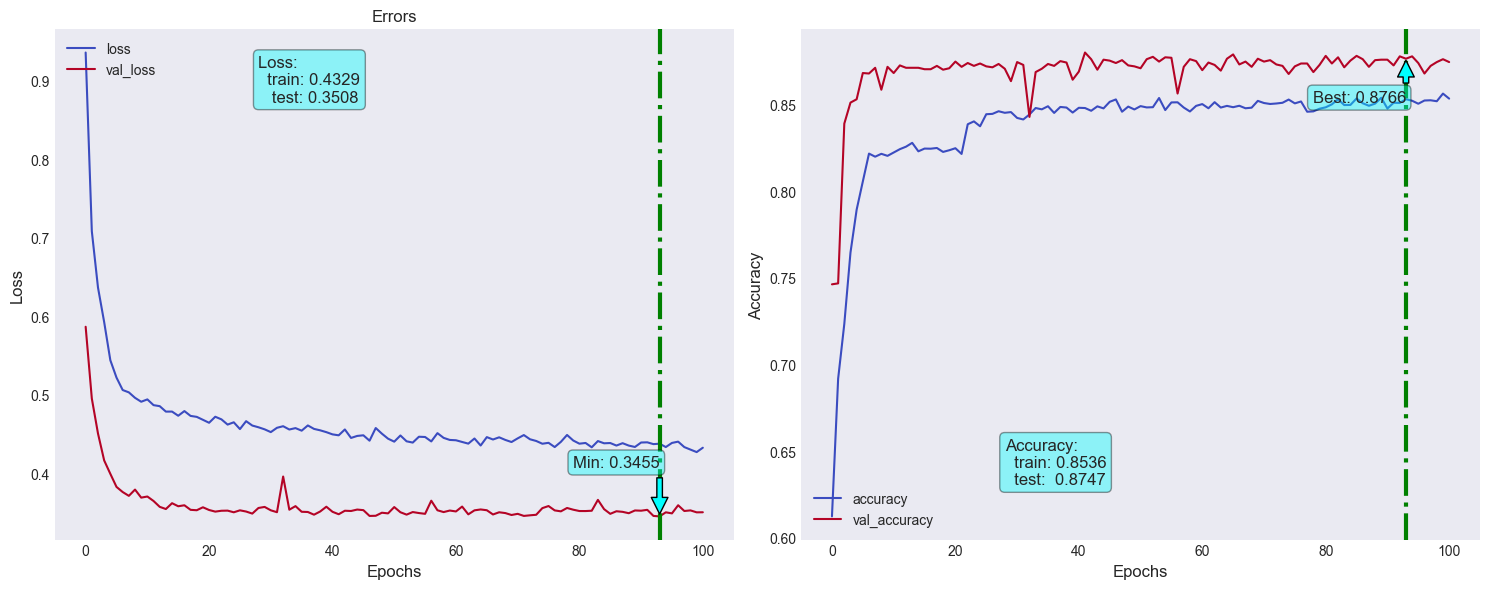

In [30]:
fn_plot_tf_hist(pd.DataFrame(history.history))

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df[loss_df['val_loss']] == lo